In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hydrant.topology.geom as gm
import subprocess
import os
from   shapely.geometry import Point

In [2]:
# inputs
path_out = './output/'
codes = ['7020014250'] # Colombia
path_riv= '/home/shg096/projects/rpp-kshook/CompHydCore/TDX_hydro/'
path_cat= '/home/shg096/projects/rpp-kshook/CompHydCore/TDX_hydro/'
riv_file_template= '*-streamnet-gpkg'
cat_file_template= '*-basins-gpkg'

In [3]:
if not os.path.isdir(path_out):
    os.makedirs(path_out)

# Load and append the pfaf

In [4]:
riv, cat = gm.tdx_read_file(codes = ['7020014250'],
                            path_riv= '/home/shg096/projects/rpp-kshook/CompHydCore/TDX_hydro/',
                            riv_file_template= '*-streamnet-gpkg',
                            path_cat= '/home/shg096/projects/rpp-kshook/CompHydCore/TDX_hydro/',
                            cat_file_template= '*-basins-gpkg')

In [5]:
cat

,streamID,geometry,hillslope,pfafcode,area
0,4,"POLYGON ((-136.34856 59.89617, -136.34842 59.8...",0,7020014250,7132945.5
1,5,"POLYGON ((-136.38403 59.87272, -136.38333 59.8...",0,7020014250,5473623.5
2,6,"MULTIPOLYGON (((-136.30158 59.82061, -136.3015...",0,7020014250,6071805.5
3,7,"MULTIPOLYGON (((-136.48739 59.81017, -136.4873...",0,7020014250,8046322.5
4,8,"POLYGON ((-136.62720 59.85906, -136.62664 59.8...",0,7020014250,22147610.0
...,...,...,...,...,...
168275,329055,"MULTIPOLYGON (((-113.46332 43.84101, -113.4633...",0,7020014250,5851264.0
168276,331039,"POLYGON ((-113.45786 43.89357, -113.45772 43.8...",0,7020014250,5865984.0
168277,333023,"POLYGON ((-121.45634 43.86357, -121.45564 43.8...",0,7020014250,851456.0
168278,335007,"POLYGON ((-111.89257 43.85823, -111.89243 43.8...",0,7020014250,1163776.0


# prepare the network topology

In [6]:
riv, cat = gm.prepare_ntopo(riv=riv,\
                            riv_cols={'id':'LINKNO', 'next_id':'DSLINKNO'},\
                            cat=cat,\
                            cat_cols={'id':'streamID', 'hillslope':'hillslope', 'area' :'area'},\
                            network = 'tdx',
                            outlet_val = -1)

[     4      5      6 ... 333023 335007 336991]
[    -1   5957     -1 ... 237790 239776 241758]
          Rank  Rank_Next  seg_id  to_segment
0       163801          0       4          -1
1         1564       1577       5        5957
2       163802          0       6          -1
3         1644       1651       7       17866
4         1652       1661       8       19850
...        ...        ...     ...         ...
168275   85711      85729  329055      331039
168276   85729      85753  331039      229860
168277  152444     152516  333023      237790
168278   99540      99640  335007      239776
168279   87053      87077  336991      241758

[168280 rows x 4 columns]
        LINKNO  DSLINKNO  DSNODEID  strmOrder  Length  Magnitude  \
0            4        -1        -1          1  2145.8          1   
1            5      5957        -1          1   966.1          1   
2            6        -1        -1          1   582.6          1   
3            7     17866        -1          1  3757.0

# Example-1 From Fraser River

In [7]:
# set the case name
prefix = 'Fraser_tdx_'

In [8]:
# slice the domain for various stations and their seg ID
cat_slice, riv_slice = gm.subset_ntopo(cat=cat,\
                                       cat_cols={'id':'streamID'},\
                                       riv=riv,\
                                       riv_cols={'id':'LINKNO', 'next_id':'DSLINKNO'},\
                                       outlet_id=[217371],
                                       outlet_val = -1) # segment that is aimed to make the subbasin for

[ 67870  38111  69852 ... 171738 149911 217371]
[ 79774  79774  67867 ... 217371 217371     -1]
        Rank  Rank_Next  seg_id  to_segment
0      15066      15135   14822      163615
1       1415       1473   16516      123649
2      16700      16803   16771      125890
3      16148      16239   16785      121934
4      14924      15001   16806      108070
...      ...        ...     ...         ...
28063  27209      27229  250970      195420
28064  26721      26749  251011      177607
28065  27301      27315  252954      219229
28066  27637      27647  256963      258947
28067  27647      27659  258947      199429

[28068 rows x 4 columns]
       LINKNO  DSLINKNO  DSNODEID  strmOrder   Length  Magnitude  \
0       14822    163615        -1          1  15205.3          1   
1       16516    123649        -1          1   6736.9          1   
2       16771    125890        -1          1   1899.5          1   
3       16785    121934        -1          1   3861.0          1   
4       16

<AxesSubplot:>

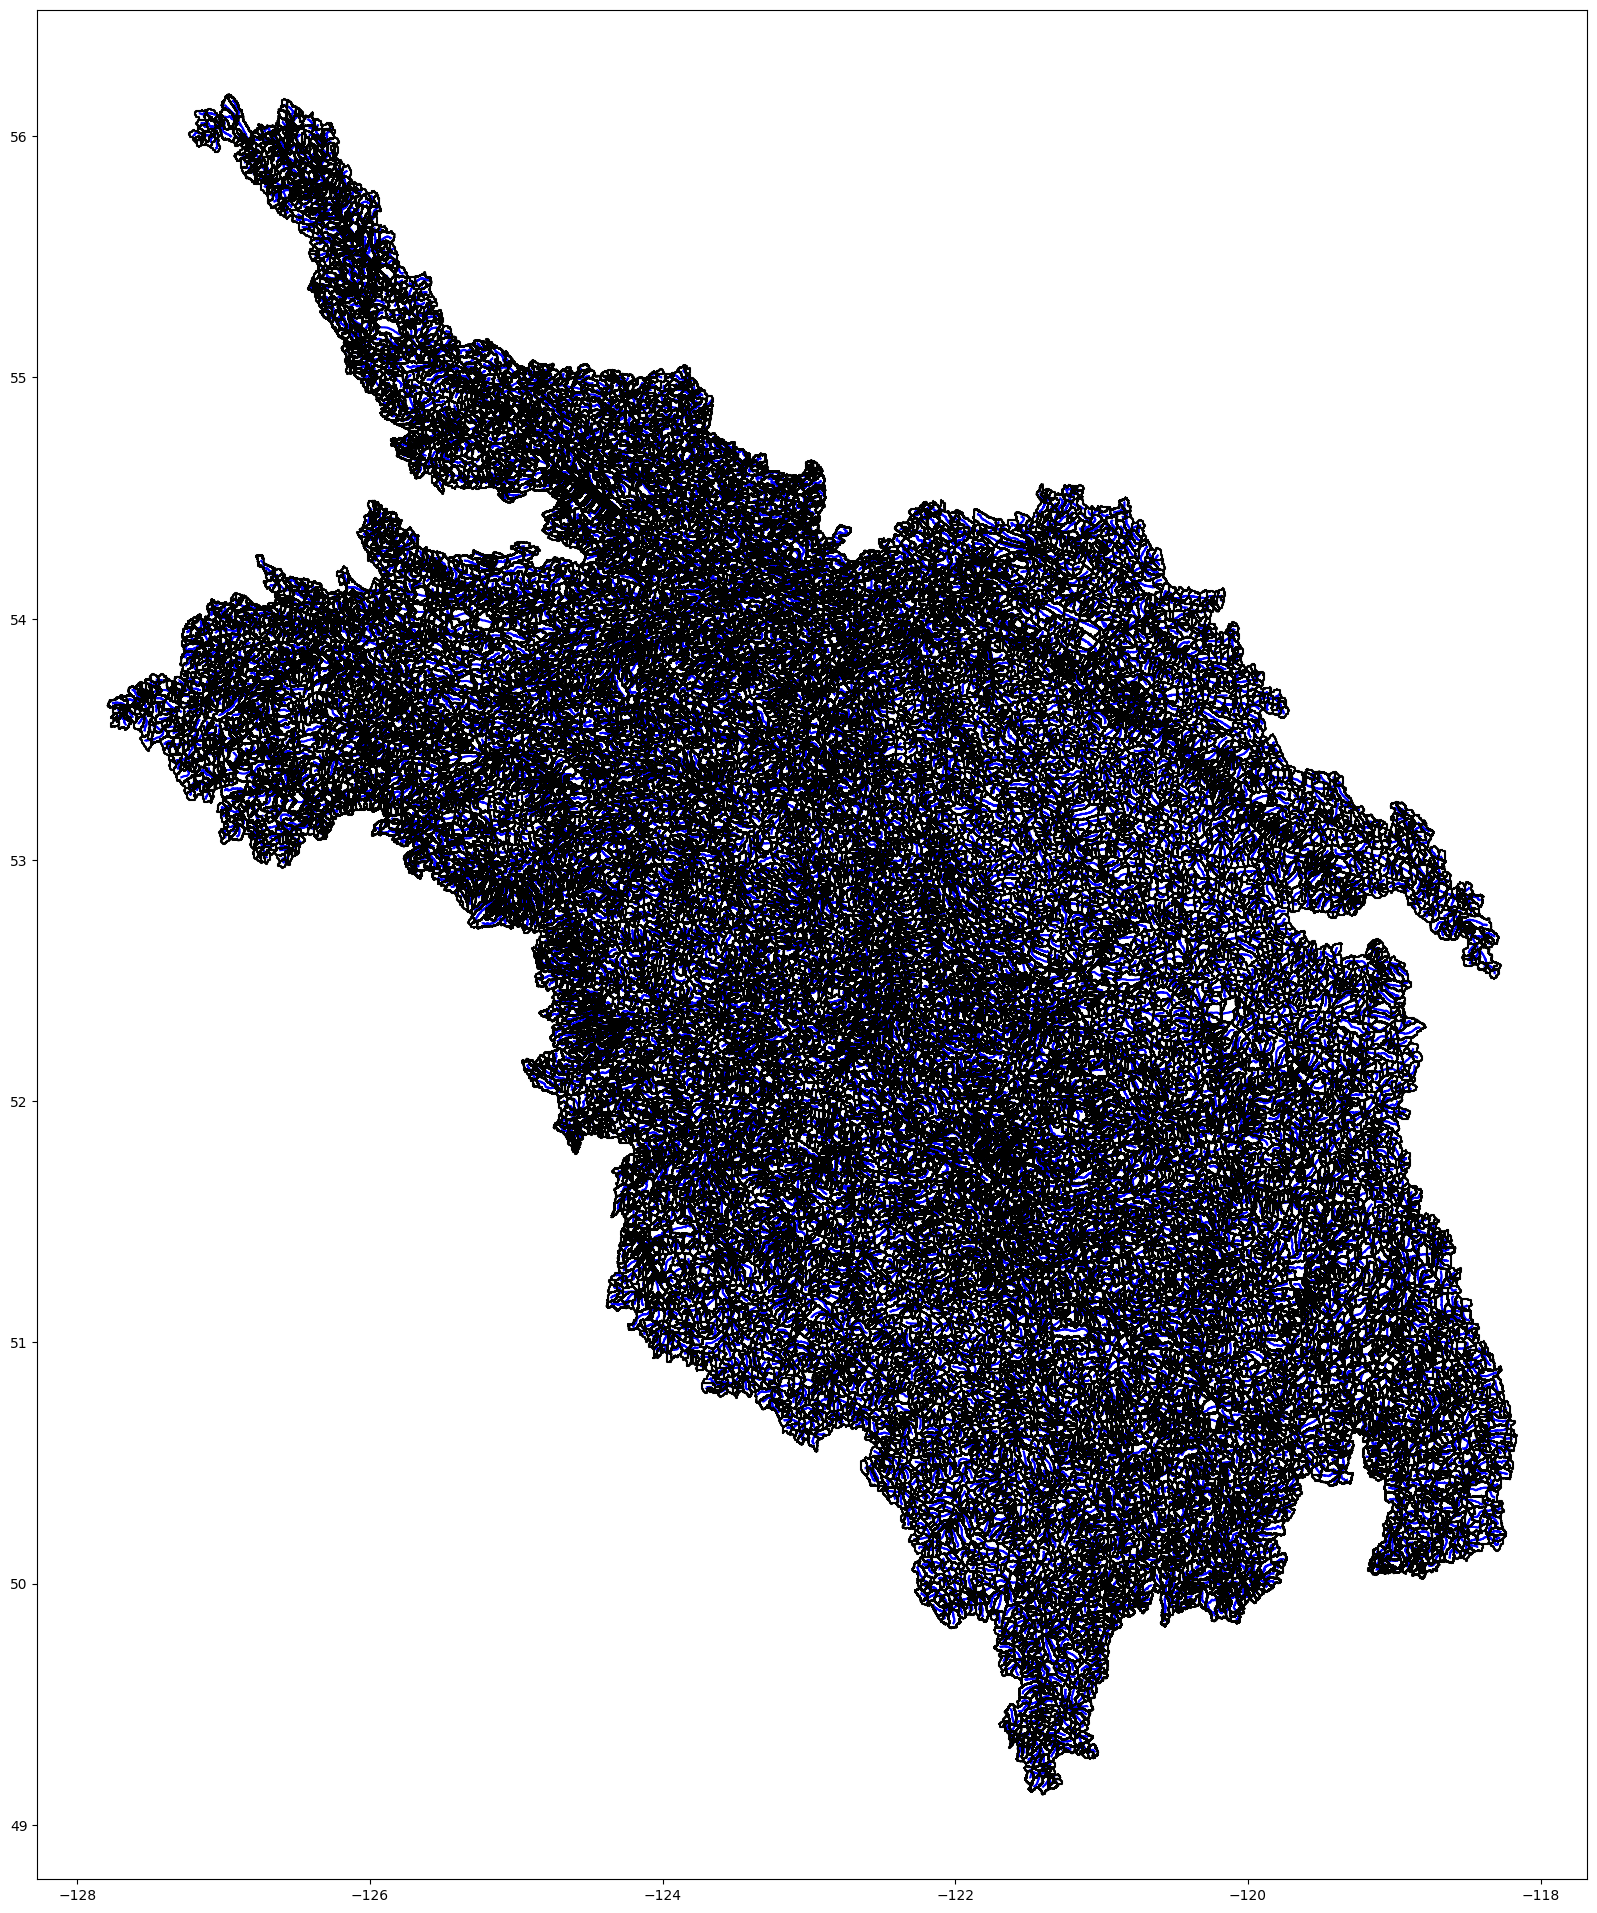

In [9]:
fig, ax = plt.subplots(figsize=(20,30))
riv_slice.plot(ax=ax, color='b')
cat_slice.boundary.plot(ax=ax, color='k')

In [11]:
xr_ntopo = gm.create_xr_ntopo(riv_slice,
                              cat_slice,
                              network = 'tdx')
xr_ntopo

UnboundLocalError: local variable 'ntopo' referenced before assignment

# Save

In [ ]:
cat_slice.to_file(path_out+prefix+'cat.shp')
riv_slice.to_file(path_out+prefix+'riv.shp')
xr_ntopo.to_netcdf(path_out+prefix+'ntopo.nc')